# 2. Работаем с собственными датасетами

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

По материалам курсов https://course.fast.ai/

*переведено, дополнено, адаптировано, расширено https://vk.com/lambda_brain*
*январь 2020*



---





В этом занятии изучим, как использовать поисковик Google Images для отбора интересующих изображений, формирования на их основе обучающих датасетов и использования их в продакшене.


In [0]:
from fastai.vision import *

## Получаем список URL-ов изображений для датасета

### Ищем и скроллируем

Идём на [Google Images](http://images.google.com) и отбираем интересующие изображения. Чем более конкретным будет запрос и, соответственно, чем чище будет итоговая выборка, тем лучше будут результаты обучения. 

Скроллируйте выдачу изображений до тех пор, пока вы не решите что их количества достаточно, или пока внизу не появится кнопка 'Show more results'. Максимально Google Images выдаёт 700 изображений.

Возможно, в запросе надо исключить явно ненужные изображения, что делается с помощью "-". Вы также можете ограничить выдачу исключительно фотографиями, что делается через меню Tools - Photos, и т. п. В целом, очистка исходной выборки может потребовать довольно больших усилий.

Например, мы хотим сформировать датасет с велосипедами, где будут и шоссейные, и горные марки, и обучить модель их классификации. Для этого выполним по очереди запросы road bikes и mountain bikes.


### Скачиваем выборку в файл

Делаем запрос road bikes, после чего выгрузим ссылки на выданные изображения в отдельный файл. В Google Chrome нажмите <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>j</kbd>, появится небольшое окно консоли JavaScript. Введите в него следующий код и нажмите Enter:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Браузер автоматически выгрузит файл (вероятно, `Без названия`) в каталог по умолчанию. Содержимое этого файла будет примерно таким:

https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRqUluiIYp4OmMGr7QaueGFRyHYbDQ5BdI6_AvlpBWtZwIBMK3e
https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTDo3i3cFNrBTUzqAHKeucoxcyZeNOOKaYK35i9QecO7IgMApnz
https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRTrQrsqKULYxfPXIHvUcxWQvSVtdUiEtzs97genrQIGN_UBtiD
...

Это и есть список нужных нам изображений. Назовём файл `roadbikes.csv`.

Повторим процедуру для горных велосипедов с запросом mountain bikes. Второй файл назовём `mtbs.csv`.

### Загружаем файлы со списком URL-ов на сервер

Выберем подходящие имена (метки) для каждой из наших подвыборок и создадим на сервере соответствующие каталоги.


In [0]:
path = Path('data/bikes')
folder = 'roadbikes' # каталог шоссейных велосипедов и метка для этой категории
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
folder = 'mtbs' # каталог горных велосипедов и метка для этой категории
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('data/bikes/roadbikes'), PosixPath('data/bikes/mtbs')]

Теперь загрузим csv-файлы в соответствующие каталоги. Для этого откройте левое меню ноутбука, выберите вкладку Files, и загрузите эти файлы с помощью локального меню.

In [0]:
!ls data/bikes/roadbikes/
!ls data/bikes/mtbs/

roadbikes.csv
mtbs.csv


## Загружаем изображения на сервер

Теперь всё готово для загрузки изображений на сервер.

**fast.ai** содержит готовую функцию `download_images()` для автоматического выполнения такой загрузки. Её нужен лишь файл со списком url-ов изображений и целевой каталог, в который они будут закачены. На всякий случай можно указать максимальное ограничение на количество файлов.

In [0]:
classes = ['roadbikes', 'mtbs']

In [0]:
folder = 'roadbikes'
file = folder + '.csv'
dest = path/folder
download_images(dest/file, dest, max_pics=200)
folder = 'mtbs'
file = folder + '.csv'
dest = path/folder
download_images(dest/file, dest, max_pics=200)

Не забывайте, что виртуальные серверы для ноутбуков Google Colab обычно перезапускаются с нуля каждые 24 часа, поэтому все ранее загруженные таким образом датасеты скорее всего пропадут.

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=False, max_size=400) # проверяем наличие изображений

roadbikes


mtbs


## Посмотрим на наши данные

Загрузим датасет (составленный из двух наборов изображений) с помощью команды `from_folder()`, упоминавшейся в предыдущем занятии. 

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Убедимся, что в нём действительно содержатся изображения двух наших категорий:

In [0]:
data.classes

['mtbs', 'roadbikes']

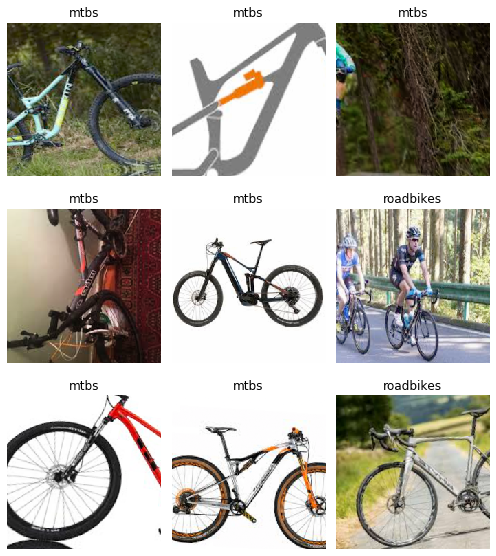

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) # размеры обучающей и тестовой выборок

(['mtbs', 'roadbikes'], 2, 312, 78)

## Обучаем модель

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate) # используем стандартную модель resnet34

In [0]:
learn.fit_one_cycle(4) # первая итерация обучения

epoch,train_loss,valid_loss,error_rate,time
0,0.395303,0.594872,0.141026,00:03
1,0.329815,0.526877,0.141026,00:03
2,0.299623,0.547623,0.128205,00:03
3,0.301349,0.554454,0.141026,00:03


In [0]:
learn.save('stage-1') # сохраним первый промежуточный результат

Как видно, качество получилось невысоким. Попробуем тонкую настройку (fine-tuning).

In [0]:
learn.unfreeze() # разморозка всей модели

In [0]:
learn.lr_find() # анализ диапазона скоростей обучения

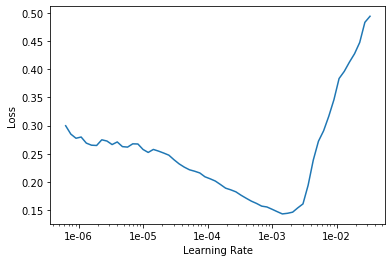

In [0]:
# Если lr_find() отработала неуспешно, можно явно задать предполагаемый диапазон:
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)

learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-3)) # задаём визуально подходящий диапазон скорости обучения

epoch,train_loss,valid_loss,error_rate,time
0,0.048862,1.195016,0.128205,00:03
1,0.059415,0.999490,0.102564,00:03


In [0]:
learn.save('stage-2') # сохраним вторые промежуточные результаты

Как видно, результат получился значительно лучше.

## Интерпретация результатов обучения

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

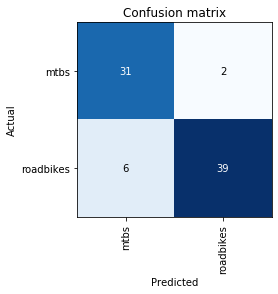

In [0]:
interp.plot_confusion_matrix() # смотрим на матрицу ошибок

Видно, что основная ошибка модели в том, что шесть шоссейных велосипедов классифицированы как горные. Давайте на них посмотрим.

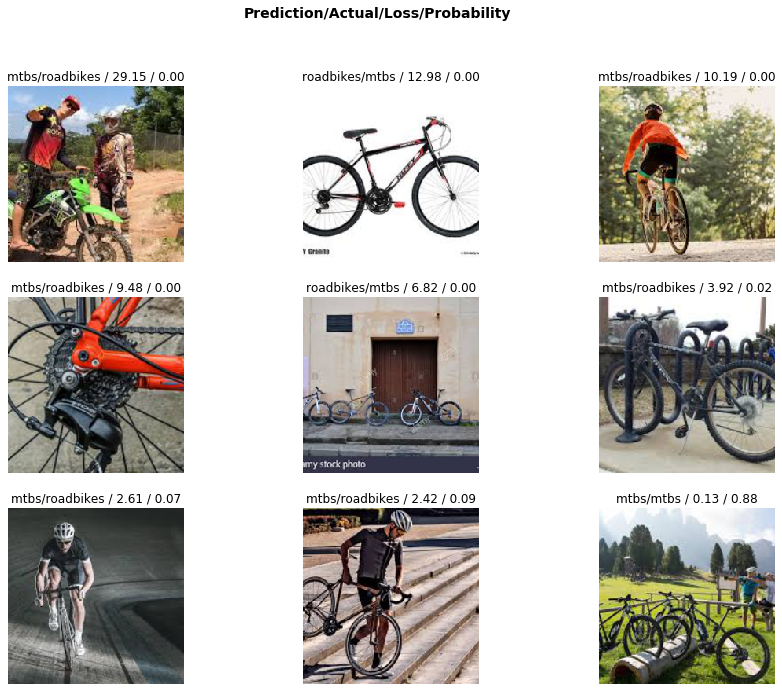

In [0]:
interp.plot_top_losses(9, figsize=(15,11))



Очевидно, что ошибка отнюдь не в классификации, а в том, что наш исходный датасет оказался довольно грязным, зашумлённым явными помехами. Различные довольно неоднозначные изображения представлены единичными примерами.

## Очистка датасета

**fast.ai** предлагает виджет `ImageCleaner` из `fastai.widgets`, который помогает очистить датасет от явного мусора. К сожалению, **в ноутбуках, запускаемых в Google Colab, виджеты запрещены**. 

Поэтому дальнейшие инструкции сработают, только если например развернуть среду Jupyter локально, и из неё подключиться к Google Drive.

In [0]:
from fastai.widgets import *

Метод виджета `from_toplosses()` на основе изображений с самыми плохими оценками формирует новый файл `cleaned.csv` с названиями этих плохих файлов.

Предварительно готовим список наших изображений.

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Готовим модель, которая будет очищена с помощью виджета.

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln) # список ошибочных изображений

In [0]:
# ImageCleaner(ds, idxs, path) ! не запускайте эту команду в виртуальном ноутбуке !

В идеале данный виджет предложит удобный графический интерфейс, в котором с помощью кнопки Delete можно помечать изображения, которые надо из датасета удалить (как говорилось, физически они не удаляются, а включаются в файл `cleaned.csv`).

**При работе в виртуальном ноутбуке датасет придётся очищать вручную.**

## Готовим модель к продакшену

Во-первых, экспортируем "содержимое" `Learner`:

In [0]:
learn.export()

В рабочем каталоге bikes будет создан файл `export.pkl`, который содержит всю необходимую информацию для использования модели.

Давайте проверим, как наша модель будет работать на обычном процессоре (не графическом).


In [0]:
defaults.device = torch.device('cpu') # задаём в качестве девайса обычный процессор

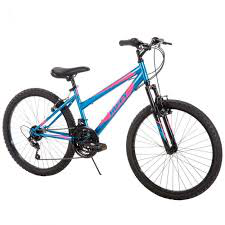

In [0]:
img = open_image(path/'mtbs'/'00000012.jpg') # выберем случайный велосипед
img

Далее подразумевается, что файл `export.pkl` (наша модель `Learner` в рабочем окружении) находится в каталоге `path`.

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img) # выполняем классификацию локального изображения
pred_class # должно получиться mtbs

Category mtbs

## Что может пойти не так

- По умолчанию обучение модели очень часто проходит достаточно успешно (точность 70-90%)
- На практике будет не так много параметров, которые вам потребуется настраивать
- Прежде всего это
  - Скорость обучения
  - Количество эпох

### Когда скорость обучения (LR) слишком высока

В таком случае из-за большого шага нужные минимумы ошибок будут пропускаться незамеченными.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,13.602516,7788698112.000000,0.576923,00:03


### Когда скорость обучения (LR) слишком маленькая

Мы не доберёмся маленьким шагом до нужного минимума ошибок, а если будем задавать слишком много эпох, проявится эффект переобучения модели.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.280921,1.166793,0.371795,00:03
1,1.279505,0.855189,0.397436,00:03
2,1.239163,0.800186,0.410256,00:03
3,1.224891,0.786548,0.397436,00:03
4,1.223914,0.810963,0.423077,00:03


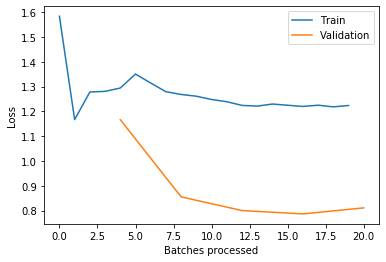

In [0]:
learn.recorder.plot_losses()

### Слишком мало эпох

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.250668,18.421618,0.576923,00:03


### Слишком много эпох

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

Большое количество ресурсов будет потрачено впустую, когда модель доберётся до предела своих возможностей, и появится эффект переобучения.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [0]:
learn.fit_one_cycle(40, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.817869,0.980337,0.487179,00:04
1,0.804286,1.031985,0.487179,00:02
2,0.701386,1.064987,0.501424,00:02
3,0.591848,1.125119,0.501424,00:02
4,0.477608,1.207992,0.484330,00:02
5,0.414455,1.196494,0.464387,00:02
6,0.366163,1.057875,0.387464,00:02
7,0.317902,0.959690,0.327635,00:02
8,0.279724,0.883870,0.282051,00:02
9,0.249232,0.910599,0.299145,00:02


# Задание

Сформируйте вышеописанным способом оригинальный датасет с не менее чем тремя категориями похожих изображений, и обучите модель до приемлемого уровня.